<h1><center>A Two-Asset Savings Model with an Income-Contribution Scheme</center></h1>
<h2><center>Mateo Velásquez-Giraldo</center></h2>
<h3><center> mvelasq2@jhu.edu </center></h3>
<h2><center> Johns Hopkins University </center></h2>

This notebook demonstrates the use of the `RiskyContrib` agent type
of the [HARK Toolkit](https://econ-ark.org/toolkit). The model represents an agent who can
save using two different assets---one risky and the other risk-free---to insure
against fluctuations in his income, but faces frictions to transferring funds between
assets. The flexibility of its implementation and its inclusion in the HARK
toolkit will allow users to adapt the model to realistic life-cycle calibrations, and
also to embedded it in heterogeneous-agents macroeconomic models.

In [1]:
# Preamble

from HARK.ConsumptionSaving.ConsRiskyContribModel import (
    RiskyContribConsumerType,
    init_risky_contrib_lifecycle,
)
from time import time
from copy import copy

import numpy as np
import seaborn as sns
import pandas as pd
from Simulations.tools import pol_funcs_dframe, age_profiles
import os

# This is a jupytext paired notebook that autogenerates a .py file
# which can be executed from a terminal command line
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
from IPython import get_ipython # In case it was run from python instead of ipython

# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if 'terminal' in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False
    
# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')

## Model Description

I now discuss the main components of the model informally, and leave its full
recursive mathematical representation for Section \ref{sec:recursive}.

### Time, mortality, and utility

Time advances in discrete steps that I will index with $t$. The model can
be used in both infinite and finite-horizon versions.

Agents face an exogenous risk of death $\delta_t$ each period, which becomes certain at the 
maximum age of the finite-horizon version. There are no intentional bequests; agents
will consume all of their resources if they reach the last period, but they can leave
accidental bequests upon premature death.

In each period, agents derive utility from consumption only. Their utility function
follows a constant relative risk aversion specification. Formally, for a level of 
consumption $C$, the agent derives instant utility
\begin{equation}
	u(C) = \frac{C^{1-\rho}}{1- \rho}.
\end{equation}

#### Income process

Agents supply labor inelastically. Their labor earnings $Y_{i,t}$ are the product of a
permanent component $P_{i,t}$ and a transitory stochastic component $\theta_{i,t}$ as
in \cite{Carroll1997qje},  where $i$ indexes different agents. Formally,
\begin{equation*}
\begin{split}
\ln Y_{i,t} &= \ln P_{i,t} + \ln \theta_{i,t} \\
\ln P_{i,t} &= \ln P_{i,t-1} + \ln \Gamma_{i,t} + \ln \psi_{i,t}
\end{split}
\end{equation*}
where $\Gamma_{i,t}$ is a deterministic growth factor that can capture
life-cycle patterns in earnings, and
$\ln \psi_{i,t}\sim \mathcal{N}(-\sigma^2_{\psi,t}/2, \sigma_{\psi,t})$
is a multiplicative shock to permanent income\footnote{The mean of the shock is set so that $E[\psi_{i,t}] = 1$.}.

The transitory component $\theta_{i,t}$ is a mixture that models unemployment and
other temporal fluctuations in income as
\begin{equation*}
\ln\theta_{i,t} = \begin{cases}
\ln \mathcal{U}, & \text{With probability } \mho\\
\ln \tilde{\theta}_{i,t}\sim\mathcal{N}(-\sigma^2_{\theta,t}/2, \sigma_{\theta,t}), & \text{With probability } 1-\mho,
\end{cases}
\end{equation*}
with $\mho$ representing the probability of unemployment and $\mathcal{U}$ the replacement
factor of unemployment benefits.

This specification of the income process is parsimonious and flexible enough to accommodate
life-cycle patterns in income growth and volatility, transitory unemployment and exogenous
retirement. Introduced by \cite{Carroll1997qje}, this income specification is common in studies
of life-cycle wealth accumulation and portfolio choice; see e.g.,
\cite{Cagetti2003jbes,Cocco2005rfs,Fagereng2017jof}. The specification has
also been used in studies of income volatility such as \cite{Carroll1992bpea,Carroll1997jme,Sabelhaus2010jme}, which have yielded calibrations of its stochastic shocks' distributions.

#### Financial assets and frictions

Agents smooth their consumption by saving and have two assets
available for this purpose. The first is a risk-free liquid account with 
constant per-period return factor $R$. The second has a stochastic return
factor $\tilde{R}$ that is log-normally distributed and independent across
time. Various interpretations such as stocks, a retirement fund, or entrepreneurial
capital could be given to the risky asset. Importantly, consumption must be paid for
using funds from the risk-free account. The levels of risk-free and risky assets
owned by the agent will both be state variables, denoted with $M_{i,t}$ and $N_{i,t}$
respectively.

Portfolio rebalancing takes place by moving funds between the risk-free
and risky accounts. These flows are one of the agents' control variables
and are denoted as $D_{i,t}$, with $D_{i,t}>0$ representing a movement of
funds from the risk-free to the risky account. Withdrawals from the risky
account are subject to a constant-rate tax $\tau$ which can represent, for
instance, capital-gains realization taxes or early retirement-fund withdrawal
penalties. In sum, denoting post-rebalancing asset levels with $\tilde{\cdot}$,
\begin{equation*}
\begin{split}
\tilde{M}_{i,t} &= M_{i,t} - D_{i,t}(1 - 1_{[D_{i,t}\leq0]}\tau)\\
\tilde{N}_{i,t} &= N_{i,t} + D_{i,t}.
\end{split}
\end{equation*}

At any given period, an agent might not be able to rebalance his portfolio.
This ability is governed by an exogenous stochastic shock that is realized
at the start of the period

\begin{equation*}
\Adj_t \sim \text{Bernoulli}(p_t),
\end{equation*}

with $\Adj_t=1$ meaning that the agent can rebalance and $\NAdj_t=1$ ($\Adj_t = 0$)
forcing him to set $D_{i,t} = 0$. This friction is a parsimonious way to capture
the fact that portfolio rebalancing is costly and households do it sporadically.
Recent studies have advocated for \cite{Giglio2021aer} and used
\cite{Luetticke2021aej_macro} this kind of rebalancing friction.

To partially evade the possibility of being unable to rebalance their accounts, agents
can use an income deduction scheme. By default, labor income ($Y_{i,t}$) is deposited to
the risk-free liquid account at the start of every period. However, agents can pre-commit
to have a fraction  $\Contr_t\in[0,1]$ of their income diverted to their risky account instead.
This fraction can be tweaked by the agent whenever $\Adj_t = 1$; otherwise it stays at its
previous value, $\Contr_{t+1} = \Contr_t$.

#### Timing

<div>
<img src="Figures/Timing_diagram.png" width="600"/>
</div>

The previous figure summarizes the timing of stochastic shocks and
optimizing decisions that occur within a period of the life cycle model.

### Recursive representation of the model

Individual subscripts $i$ are dropped for simplicity. The value function for
an agent who is not allowed to rebalance his portfolio at time $t$ is

\begin{equation*}
\begin{split}
V^{\NAdj}_{t}(M_t, N_t, P_t, \Contr_t) = \max_{C_t} u(C_t) 
+ p_{t+1} &\beta\delta_{t+1} E_t \left[  V^{\Adj}_{t+1}\left( M_{t+1}, N_{t+1}, 
P_{t+1} \right)\right] +\\
\left(1-p_{t+1}\right) &\beta\delta_{t+1} E_t\left[V^{\NAdj}_{t+1}\left(M_{t+1}, 
N_{t+1}, P_{t+1}, \Contr_{t+1}\right) \right]\\
\text{Subject to:} \quad &\\
0\leq& C_t \leq M_t \\
A_t =& M_t - C_t \\
M_{t+1} =& R A_t + (1-\Contr_{t+1}) Y_{t+1}\\
N_{t+1} =& \tilde{R}_{t+1}N_t + \Contr_{t+1}Y_{t+1}\\
P_{t+1} =& \Gamma_{t+1} \psi_{t+1} P_{t}\\
Y_{t+1} =& \theta_{t+1} P_{t+1}\\
\Contr_{t+1} =& \Contr_t
\end{split}
\end{equation*}

and that of agent who is allowed to rebalance is

\begin{equation*}
\begin{split}
V^{\Adj}_{t}(M_t, N_t, P_t) = \max_{C_t,D_t,\Contr_{t+1}} 
u(C_t) + p_{t+1} &\beta\delta_{t+1} E_t \left[  V^{\Adj}_{t+1}\left( M_{t+1}, 
N_{t+1}, P_{t+1} \right)\right] +\\
\left(1-p_{t+1}\right) &\beta\delta_{t+1} E_t\left[V^{\NAdj}_{t+1}\left(M_{t+1}, 
N_{t+1}, P_{t+1}, \Contr_{t+1}\right) \right]\\
\text{Subject to:} \quad &\\
\quad -N_t \leq D_t \leq M_t, \quad \Contr_{t+1} \in& [0,1], \quad 0 \leq C_t \leq \tilde{M}_t\\
\hfill\\
\tilde{M}_t =& M_t - D_t\left(1-1_{[D_t\leq0]}\tau\right)\\
\tilde{N}_t =& N_t + D_t\\
A_t =& \tilde{M}_t - C_t \\
M_{t+1} =& R A_t + (1-\Contr_{t+1}) Y_{t+1}\\
N_{t+1} =& \tilde{R}_{t+1} \tilde{N}_t + \Contr_{t+1}Y_{t+1}\\
P_{t+1} =& \Gamma_{t+1}\psi_{t+1} P_{t}\\
Y_{t+1} =& \theta_{t+1} P_{t+1}
\end{split}
\end{equation*}

## Parametrizations

This notebook will only demonstrate a life-cycle calibration of the model. However, the current implementation of the model is able to find and use the solution to infinite-horizon formulations (see the document in this repository for details).

For the present exercise, I calibrate the model's mortality and income paths to represent  individuals who enter the model at age 25, retire exogenously at 65, and live to a maximum age of 90. Survival probabilities ($\delta$) come from the 2004 SSA life-tables for males. Income growth factors and volatilities ($\Gamma$, $\sigma_\psi$, $\sigma_\theta$) come from the calibration for high-school graduates in \cite{Cagetti2003jbes}.

To highlight the effect of different financial frictions on wealth accumulation and portfolio choice, I consider different configurations for the risky-withdrawal tax $\tau$ and the probability of being able to rebalance $p$:

\begin{itemize}
\item \textbf{Base}: the probability of being able to rebalance is $p = 1$
and the risky withdrawal tax rate is $\tau = 0$, both constant throughout the agents' lives.

\item \textbf{Tax}: the risky withdrawal tax is constant at $10\%$ and the agents
can always rebalance their portfolios.

\item \textbf{Calvo}: there is no risky withdrawal tax, but there is only a $25\%$ chance
that agents can rebalance their portfolios every year.

\item \textbf{Retirement}: there is no risky withdrawal tax, but the agents' ability
to rebalance their portfolio is time-varying; they can rebalance their assets and pick
their income-deduction scheme for certain when they enter the model at age 25, but
then they have no chance of doing so again ($p=0$) until they retire. After retirement
at age 65, they can always rebalance their portfolio ($p=1$).
\end{itemize}

The rest of the parameters take the following values

| Name in HARK | Mathematical Symbol   | Value   |
|--------------|-----------------------|---------|
| `CRRA`       | $\rho$                | $5.0$   |
| `Rfree`      | $R$                   | $1.03$  |
| `DiscFac`    | $\beta$               | $0.9$   |
| `UnempPrb`   | $\mho$                | $0.05$  |
| `IncUnemp`   | $\mathcal{U}$         | $0.3$   |
| `RiskyAvg`   | $E[\tilde{R}]$        | $1.08$  |
| `RiskyStd`   | $\sqrt{V[\tilde{R}]}$ | $0.18$  |





In [2]:
# Base calibration setup

# Make the problem life-cycle
par_LC_base = init_risky_contrib_lifecycle.copy()

# Turn off aggregate growth
par_LC_base['PermGroFacAgg'] = 1.0

# and frictionless to start
par_LC_base["AdjustPrb"] = 1.0
par_LC_base["tau"] = 0.0

# Make contribution shares a continuous choice
par_LC_base["DiscreteShareBool"] = False
par_LC_base["vFuncBool"] = False

# Make grids go up to higher levels of resources
# (one of the calibration produces high levels of nNrm)
par_LC_base.update({"mNrmMax": 500, "nNrmMax":500,
                    "aXtraCount": 20, "mNrmCount": 20, "nNrmCount": 20})

In [3]:
# Alternative calibrations

# Tax
par_LC_tax = copy(par_LC_base)
par_LC_tax["tau"] = 0.1

# Calvo
par_LC_calvo = copy(par_LC_base)
par_LC_calvo["AdjustPrb"] = 0.25

# Retirement
par_LC_retirement = copy(par_LC_base)
par_LC_retirement["AdjustPrb"] = [1.0] + [0.0]*39 + [1.0]*25
par_LC_retirement["tau"] = [0.0]*41 + [0.0]*24
par_LC_retirement["UnempPrb"] = 0.0

## Solution

With the parametrizations created, I now create and solve the agents.

In [4]:
agents = {
    "Base": RiskyContribConsumerType(**par_LC_base),
    "Tax": RiskyContribConsumerType(**par_LC_tax),
    "Calvo": RiskyContribConsumerType(**par_LC_calvo),
    "Retirement": RiskyContribConsumerType(**par_LC_retirement),
}

agents = {
    "Base": RiskyContribConsumerType(**par_LC_base),
}

for agent in agents:

    print("Now solving " + agent)
    t0 = time()
    agents[agent].solve(verbose=True)
    t1 = time()
    print("Solving " + agent + " took " + str(t1 - t0) + " seconds.")

Now solving Base
Finished cycle #1 of 1 in 24.83019256591797 seconds.
Solving Base took 24.83019256591797 seconds.


## Policy function inspection

Once agents have been solved, we can use their policy functions $\dFrac_t(m,n)$, $\Contr_t(\tilde{m},\tilde{n})$, and $c_t(\tilde{m},\tilde{n}, \Contr)$ for any period $t$.

In [5]:
# Example
calib = "Base"
t = 0
print(agents[calib].solution[t].stage_sols["Reb"].dfracFunc_Adj(1,1))
print(agents[calib].solution[t].stage_sols["Sha"].ShareFunc_Adj(1.2,0.8))
print(agents[calib].solution[t].stage_sols["Cns"].cFunc(1.2,0.8,0.5))

0.05043745313422114
0.0
0.6973519012061368


I now illustrate the policy functions of different calibrations for an arbitrary period graphically.

Note that the solution algorithm represents the three simultaneous decisions that an agent can take as happening sequentially in ''stages'', in the order `Rebalancing` -> `Income deduction share` -> `Consumption`. See the document in this repository for more details.

In [6]:
# Setup
from HARK.utilities import (
    determine_platform,
    test_latex_installation,
    setup_latex_env_notebook,
)

pf = determine_platform()
try:
    latexExists = test_latex_installation(pf)
except ImportError:  # windows and MacOS requires manual install
    latexExists = False

setup_latex_env_notebook(pf, latexExists)

# General aesthetics
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Parameters to feed to policy functions
t = 10
age = t + 24
mNrmGrid = np.linspace(0, 40, 100)
nNrm_vals = np.array([0.0, 20.0, 40])
Share_vals = np.array([0.0, 0.5])

# Evaluate policy functions
polfuncs = pol_funcs_dframe(agents, t, mNrmGrid, nNrm_vals, Share_vals)

### Rebalancing

The solution to this stage problem will be the policy function $d_t(\cdot, \cdot)$
that gives the optimal flow from risk-free to risky assets, which can be negative.
However, it is convenient to define a normalized policy function $\dFrac_t$ as
\begin{equation*}
\dFrac_t(m, n) = \begin{cases}
d_t(m,n)/m, & \text{ if } d_t(m,n) \geq 0 \\
d_t(m,n)/n, & \text{ if } d_t(m,n) < 0
\end{cases}
\end{equation*}
so that $-1 \leq \dFrac(m,n) \leq 1$ for all $(m,n)$.

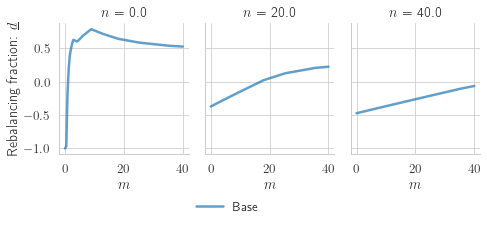

In [7]:
# Rebalancing fraction
polfuncs["$n$"] = polfuncs["n"]
g = sns.FacetGrid(
    polfuncs[polfuncs.control == "dfrac"],
    col="$n$",
    hue="model",
    height=3,
    aspect=(7 / 3) * 1 / 3,
)
g.map(sns.lineplot, "m", "value", alpha=0.7)
g.add_legend(bbox_to_anchor=[0.5, 0.0], ncol=4, title="")
g.set_axis_labels("$m$", "Rebalancing fraction: $\dFrac$")

### Income deduction share

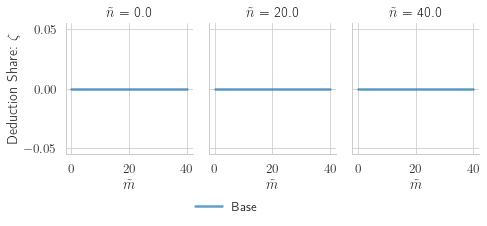

In [8]:
# After rebalancing, m and n turn to their "tilde" versions. Create ntilde
# just for seaborn's grid labels.
polfuncs["$\\tilde{n}$"] = polfuncs["n"]
polfuncs["$\\Contr$"] = polfuncs["Share"]

# Share fraction
g = sns.FacetGrid(
    polfuncs[polfuncs.control == "Share"],
    col="$\\tilde{n}$",
    hue="model",
    height=3,
    aspect=(7 / 3) * 1 / 3,
)
g.map(sns.lineplot, "m", "value", alpha=0.7)
g.add_legend(bbox_to_anchor=[0.5, 0.0], ncol=4, title="")
g.set_axis_labels("$\\tilde{m}$", r"Deduction Share: $\Contr$")

### Consumption

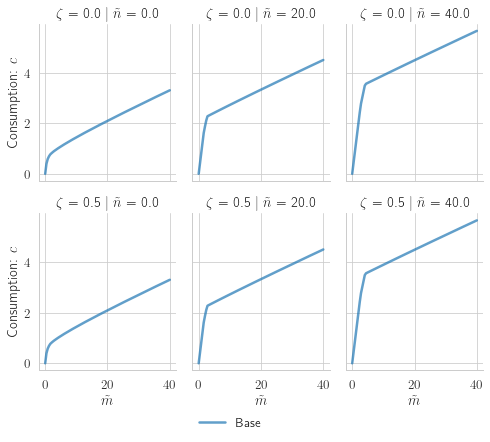

In [9]:
# Consumption
g = sns.FacetGrid(
    polfuncs[polfuncs.control == "c"],
    col="$\\tilde{n}$",
    row="$\\Contr$",
    hue="model",
    height=3,
    aspect=(7 / 3) * 1 / 3,
)
g.map(sns.lineplot, "m", "value", alpha=0.7)
g.add_legend(bbox_to_anchor=[0.5, 0.0], ncol=4, title="")
g.set_axis_labels("$\\tilde{m}$", "Consumption: $c$")

## Simulation and average life-cycle profiles

With the policy functions, it is easy to simulate populations of agents. I now simulate many agents for every calibration to obtain the average lifetime profiles of relevant variables like consumption, income, and wealth in its different components.

In [10]:
# Simulation

n_agents = 100
t_sim    = 500
profiles = []
for agent in agents:
    agents[agent].AgentCount = n_agents
    agents[agent].T_sim = t_sim
    agents[agent].track_vars = ['pLvl','t_age','Adjust',
                                'mNrm','nNrm','mNrmTilde','nNrmTilde','aNrm',
                                'cNrm', 'Share', 'dfrac']
    agents[agent].initialize_sim()
    agents[agent].simulate()
    profile = age_profiles(agents[agent])
    profile['Model'] = agent
    profiles.append(profile)

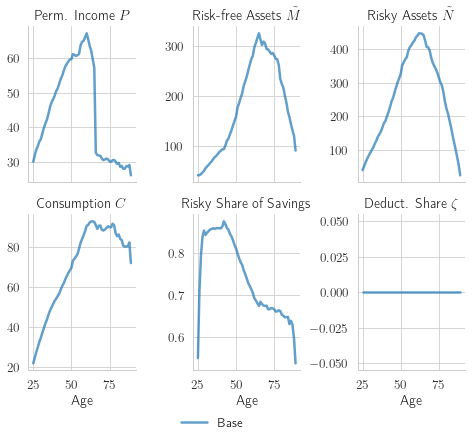

In [11]:
# Plot

simdata = pd.concat(profiles)

# Latex names
simdata = simdata.rename(columns = {'pLvl': 'Perm. Income $P$',
                 'Mtilde': 'Risk-free Assets $\\tilde{M}$',
                 'Ntilde': 'Risky Assets $\\tilde{N}$',
                 'C': 'Consumption  $C$',
                 'StockShare': 'Risky Share of Savings',
                 'Share': 'Deduct. Share $\\Contr$'})

lc_means = pd.melt(simdata,
                   id_vars = ['t_age', 'Model'],
                   value_vars = ['Perm. Income $P$',
                                 'Risk-free Assets $\\tilde{M}$',
                                 'Risky Assets $\\tilde{N}$',
                                 'Consumption  $C$',
                                 'Risky Share of Savings','Deduct. Share $\\Contr$'])

lc_means['Age'] = lc_means['t_age'] + 24

# Drop the last year, as people's behavior is substantially different.
lc_means = lc_means[lc_means['Age']<max(lc_means['Age'])]

# General aesthetics
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

g = sns.FacetGrid(
    lc_means,
    col="variable",
    col_wrap = 3,
    hue="Model",
    height=3,
    aspect=(7 / 3) * 1 / 3,
    sharey=False
)
g.map(sns.lineplot, "Age", "value", alpha=0.7)
g.add_legend(bbox_to_anchor=[0.5, 0.0], ncol=4, title="")
g.set_axis_labels("Age", "")
g.set_titles(col_template = '{col_name}')

# References

(<a id="cit-Carroll1997qje" href="#call-Carroll1997qje">Carroll, 1997</a>) Carroll Christopher D., ``_Buffer-Stock Saving and the Life Cycle/Permanent Income Hypothesis*_'', The Quarterly Journal of Economics, vol. 112, number 1, pp. 1-55, 02 1997.  [online](https://doi.org/10.1162/003355397555109)

(<a id="cit-Cagetti2003jbes" href="#call-Cagetti2003jbes">Cagetti, 2003</a>) Cagetti Marco, ``_Wealth Accumulation Over the Life Cycle and Precautionary Savings_'', Journal of Business \& Economic Statistics, vol. 21, number 3, pp. 339-353,  2003.  [online](https://doi.org/10.1198/073500103288619007

)

(<a id="cit-Cocco2005rfs" href="#call-Cocco2005rfs">Cocco, Gomes <em>et al.</em>, 2005</a>) Cocco Jo\~ao F., Gomes Francisco J. and Maenhout Pascal J., ``_Consumption and Portfolio Choice over the Life Cycle_'', The Review of Financial Studies, vol. 18, number 2, pp. 491-533, 02 2005.  [online](https://doi.org/10.1093/rfs/hhi017)

(<a id="cit-Fagereng2017jof" href="#call-Fagereng2017jof">Fagereng, Gottlieb <em>et al.</em>, 2017</a>) Fagereng Andreas, Gottlieb Charles and Guiso Luigi, ``_Asset Market Participation and Portfolio Choice over the
	Life-Cycle_'', The Journal of Finance, vol. 72, number 2, pp. 705-750,  2017.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.12484)

(<a id="cit-Carroll1992bpea" href="#call-Carroll1992bpea">Carroll, 1992</a>) Carroll Christopher D., ``_The Buffer-Stock Theory of Saving: Some Macroeconomic Evidence_'', Brookings Papers on Economic Activity, vol. 1992, number 2, pp. 61--156,  1992.  [online](http://www.jstor.org/stable/2534582)

(<a id="cit-Carroll1997jme" href="#call-Carroll1997jme">Carroll and Samwick, 1997</a>) Carroll Christopher D. and Samwick Andrew A., ``_The nature of precautionary wealth_'', Journal of Monetary Economics, vol. 40, number 1, pp. 41-71,  1997.  [online](https://www.sciencedirect.com/science/article/pii/S0304393297000366)

(<a id="cit-Sabelhaus2010jme" href="#call-Sabelhaus2010jme">Sabelhaus and Song, 2010</a>) Sabelhaus John and Song Jae, ``_The great moderation in micro labor earnings_'', Journal of Monetary Economics, vol. 57, number 4, pp. 391-403,  2010.  [online](https://www.sciencedirect.com/science/article/pii/S0304393210000358)

(<a id="cit-Giglio2021aer" href="#call-Giglio2021aer">Giglio, Maggiori <em>et al.</em>, 2021</a>) Giglio Stefano, Maggiori Matteo, Stroebel Johannes <em>et al.</em>, ``_Five Facts about Beliefs and Portfolios_'', American Economic Review, vol. 111, number 5, pp. 1481-1522, May 2021.  [online](https://www.aeaweb.org/articles?id=10.1257/aer.20200243)

(<a id="cit-Luetticke2021aej_macro" href="#call-Luetticke2021aej_macro">Luetticke, 2021</a>) Luetticke Ralph, ``_Transmission of Monetary Policy with Heterogeneity in Household Portfolios_'', American Economic Journal: Macroeconomics, vol. 13, number 2, pp. 1-25, April 2021.  [online](https://www.aeaweb.org/articles?id=10.1257/mac.20190064)

